# Problem 1

## Import necessary libraries

In [ ]:
!pip install -q kagglehub

import kagglehub
import zipfile
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import copy
from google.colab import drive
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cuda


## Mount Google Drive

In [3]:
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

checkpoint_dir = '/content/drive/MyDrive/Sports_Classification_Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
best_model_path = os.path.join(checkpoint_dir, 'best_sportvgg_model.pth')
print(f"Model checkpoints will be saved to: {checkpoint_dir}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.
Model checkpoints will be saved to: /content/drive/MyDrive/Sports_Classification_Checkpoints


## Download the dataset from Kaggle

In [4]:
print("Accessing dataset from Kaggle Hub...")
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print(f"Dataset is available at: {path}")

base_dir = path
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

print("\nVerifying directory structure:")
print(f"Train directory: {train_dir} (Exists: {os.path.exists(train_dir)})")
print(f"Validation directory: {valid_dir} (Exists: {os.path.exists(valid_dir)})")
print(f"Test directory: {test_dir} (Exists: {os.path.exists(test_dir)})")

Accessing dataset from Kaggle Hub...
Dataset is available at: /kaggle/input/sports-classification

Verifying directory structure:
Train directory: /kaggle/input/sports-classification/train (Exists: True)
Validation directory: /kaggle/input/sports-classification/valid (Exists: True)
Test directory: /kaggle/input/sports-classification/test (Exists: True)


## Define data loaders and data transformers

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, data_transforms['valid']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['valid']}")
print(f"Number of test images: {dataset_sizes['test']}")
print(f"Number of classes: {len(class_names)}")

Number of training images: 13492
Number of validation images: 500
Number of test images: 500
Number of classes: 100


## Show 10 sample images

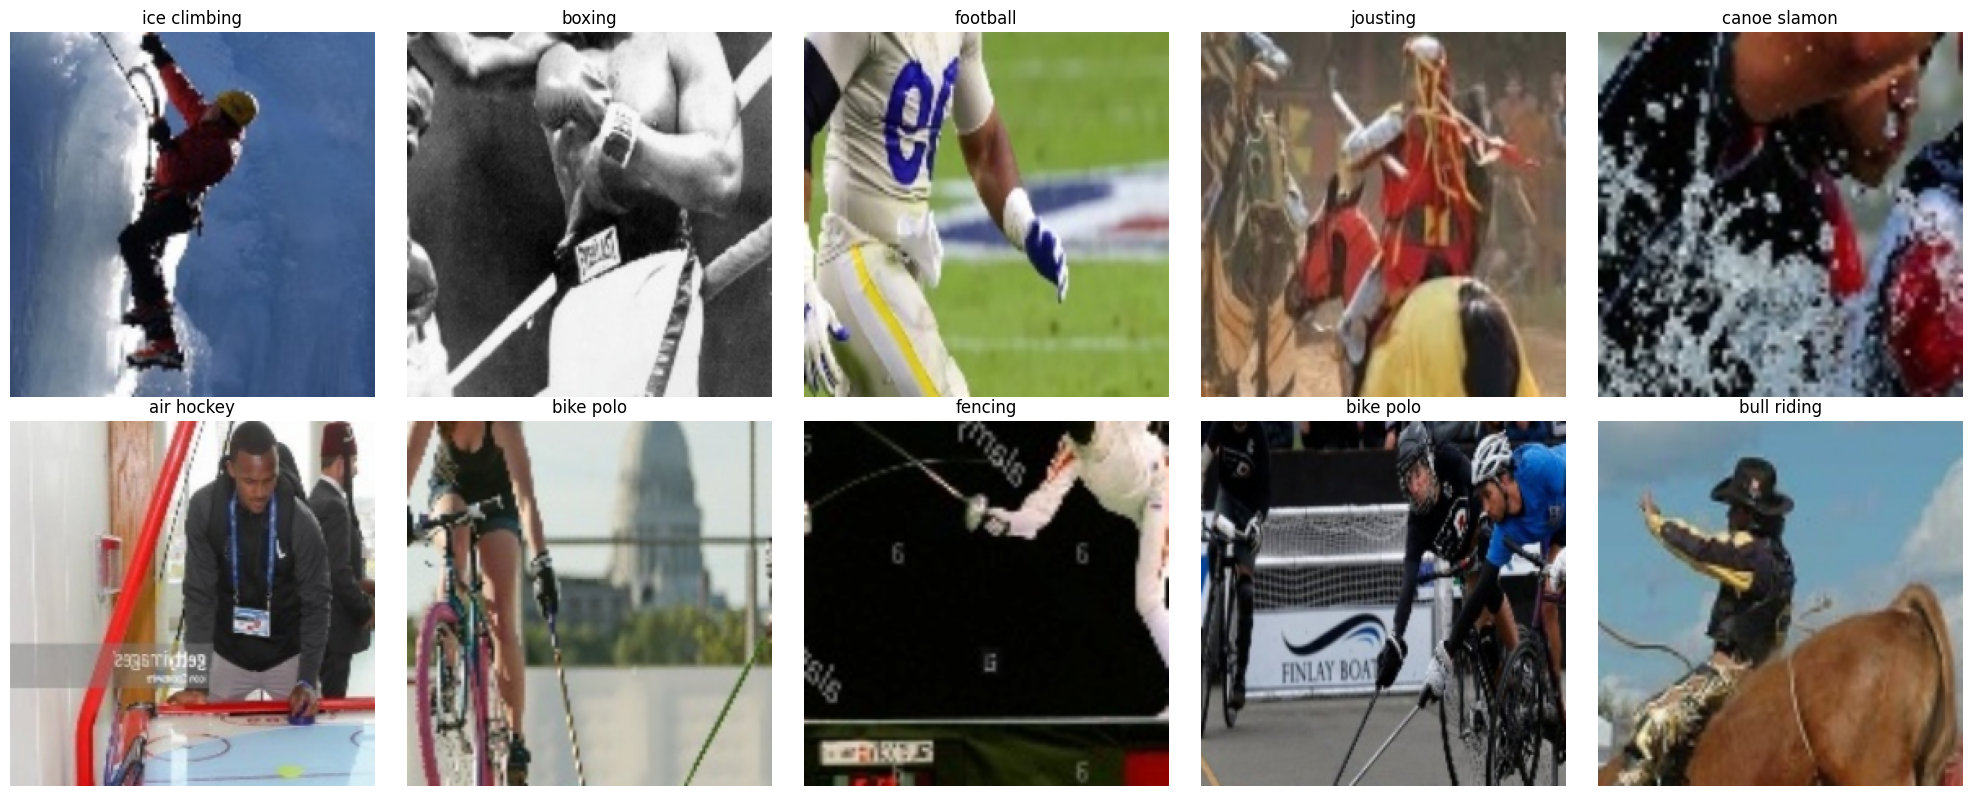

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, wrap=True)
    plt.axis('off')

inputs, classes = next(iter(dataloaders['train']))

fig = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    imshow(inputs[i], title=class_names[classes[i]])
plt.tight_layout()
plt.show()

## Define the model

In [ ]:
class SportVGG(nn.Module):
    def __init__(self, num_classes=100):
        super(SportVGG, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        self.features = vgg.features[:36]
        self.conv1x1 = nn.Conv2d(in_channels=512, out_channels=256,
                                 kernel_size=1, stride=1, bias=False)
        with torch.no_grad():
            self.conv1x1.weight.zero_()
            idx = torch.arange(256)
            self.conv1x1.weight.data[idx, 2 * idx, 0, 0] = 1
            self.conv1x1.weight.data[idx, 2 * idx + 1, 0, 0] = 1

        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        feature_maps = self.conv1x1(x)
        x_flat = feature_maps.view(feature_maps.size(0), -1)
        x_out = self.classifier(x_flat)
        return x_out, feature_maps

model = SportVGG(num_classes=len(class_names)).to(device)

for param in model.features.parameters():
    param.requires_grad = False
a
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("Model instantiated. Initial feature layers are frozen.")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s] 


Model instantiated. Initial feature layers are frozen.


## Model Training

In [8]:
def train_model(model, criterion, optimizer, checkpoint_path, num_epochs=15):
    since = time.time()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("--- Starting Training ---")

    epoch_pbar = tqdm(range(num_epochs), desc="Total Progress")

    for epoch in epoch_pbar:
        if epoch == 5:
            print("\nUnfreezing all layers and reducing learning rate for fine-tuning.")
            for param in model.features.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-4)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            batch_pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}", leave=False)

            for inputs, labels in batch_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                batch_pbar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'valid':
                epoch_pbar.set_postfix(val_loss=epoch_loss, val_acc=epoch_acc.item())

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), checkpoint_path)

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(checkpoint_path))
    return model, history

model, history = train_model(model, criterion, optimizer, checkpoint_path=best_model_path, num_epochs=15)

--- Starting Training ---


Total Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Train Epoch 1:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]


Unfreezing all layers and reducing learning rate for fine-tuning.


Train Epoch 6:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 7:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 8:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 9:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 10:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 11:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 12:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 13:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 14:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]

Train Epoch 15:   0%|          | 0/422 [00:00<?, ?it/s]

Valid Epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]


Training complete in 54m 2s
Best val Acc: 0.876000


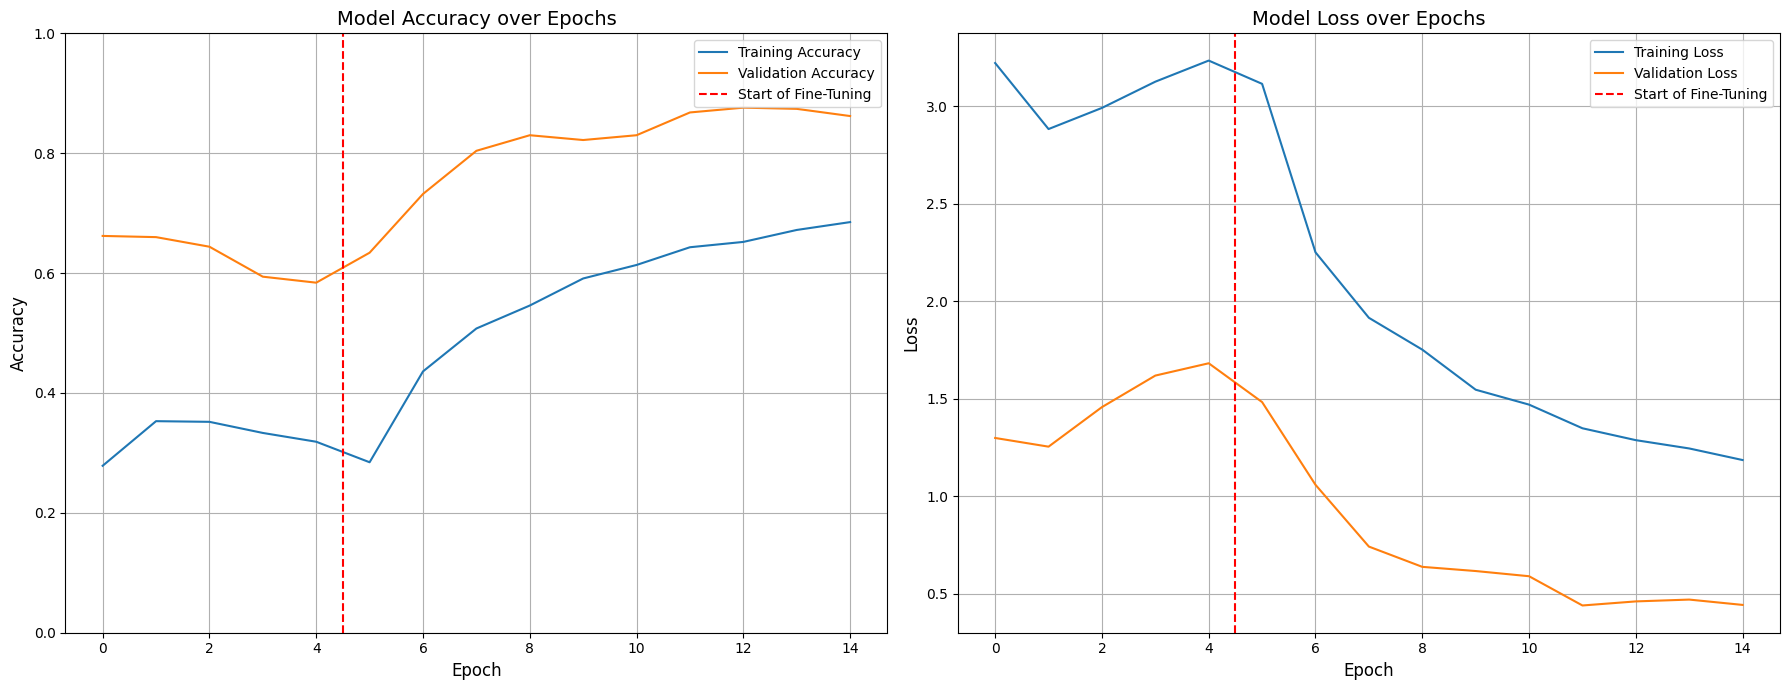

In [9]:
import matplotlib.pyplot as plt

epochs_phase1 = 5
total_epochs = len(history['train_acc'])
epochs = range(total_epochs)

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.axvline(x=epochs_phase1 - 0.5, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True)
plt.legend()
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.axvline(x=epochs_phase1 - 0.5, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.title('Model Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Model evaluation

In [10]:
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating on Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

print(f"\nLoading best model from: {best_model_path}")
final_model = SportVGG(num_classes=len(class_names))
final_model.load_state_dict(torch.load(best_model_path))
final_model = final_model.to(device)

test_accuracy = evaluate_model(final_model, dataloaders['test'])
print(f"\nFinal accuracy on the test set: {test_accuracy * 100:.2f}%")


Loading best model from: /content/drive/MyDrive/Sports_Classification_Checkpoints/best_sportvgg_model.pth


Evaluating on Test Set:   0%|          | 0/16 [00:00<?, ?it/s]


Final accuracy on the test set: 89.60%


## Model Explainability


--- Running Grad-CAM on 10 random validation images ---


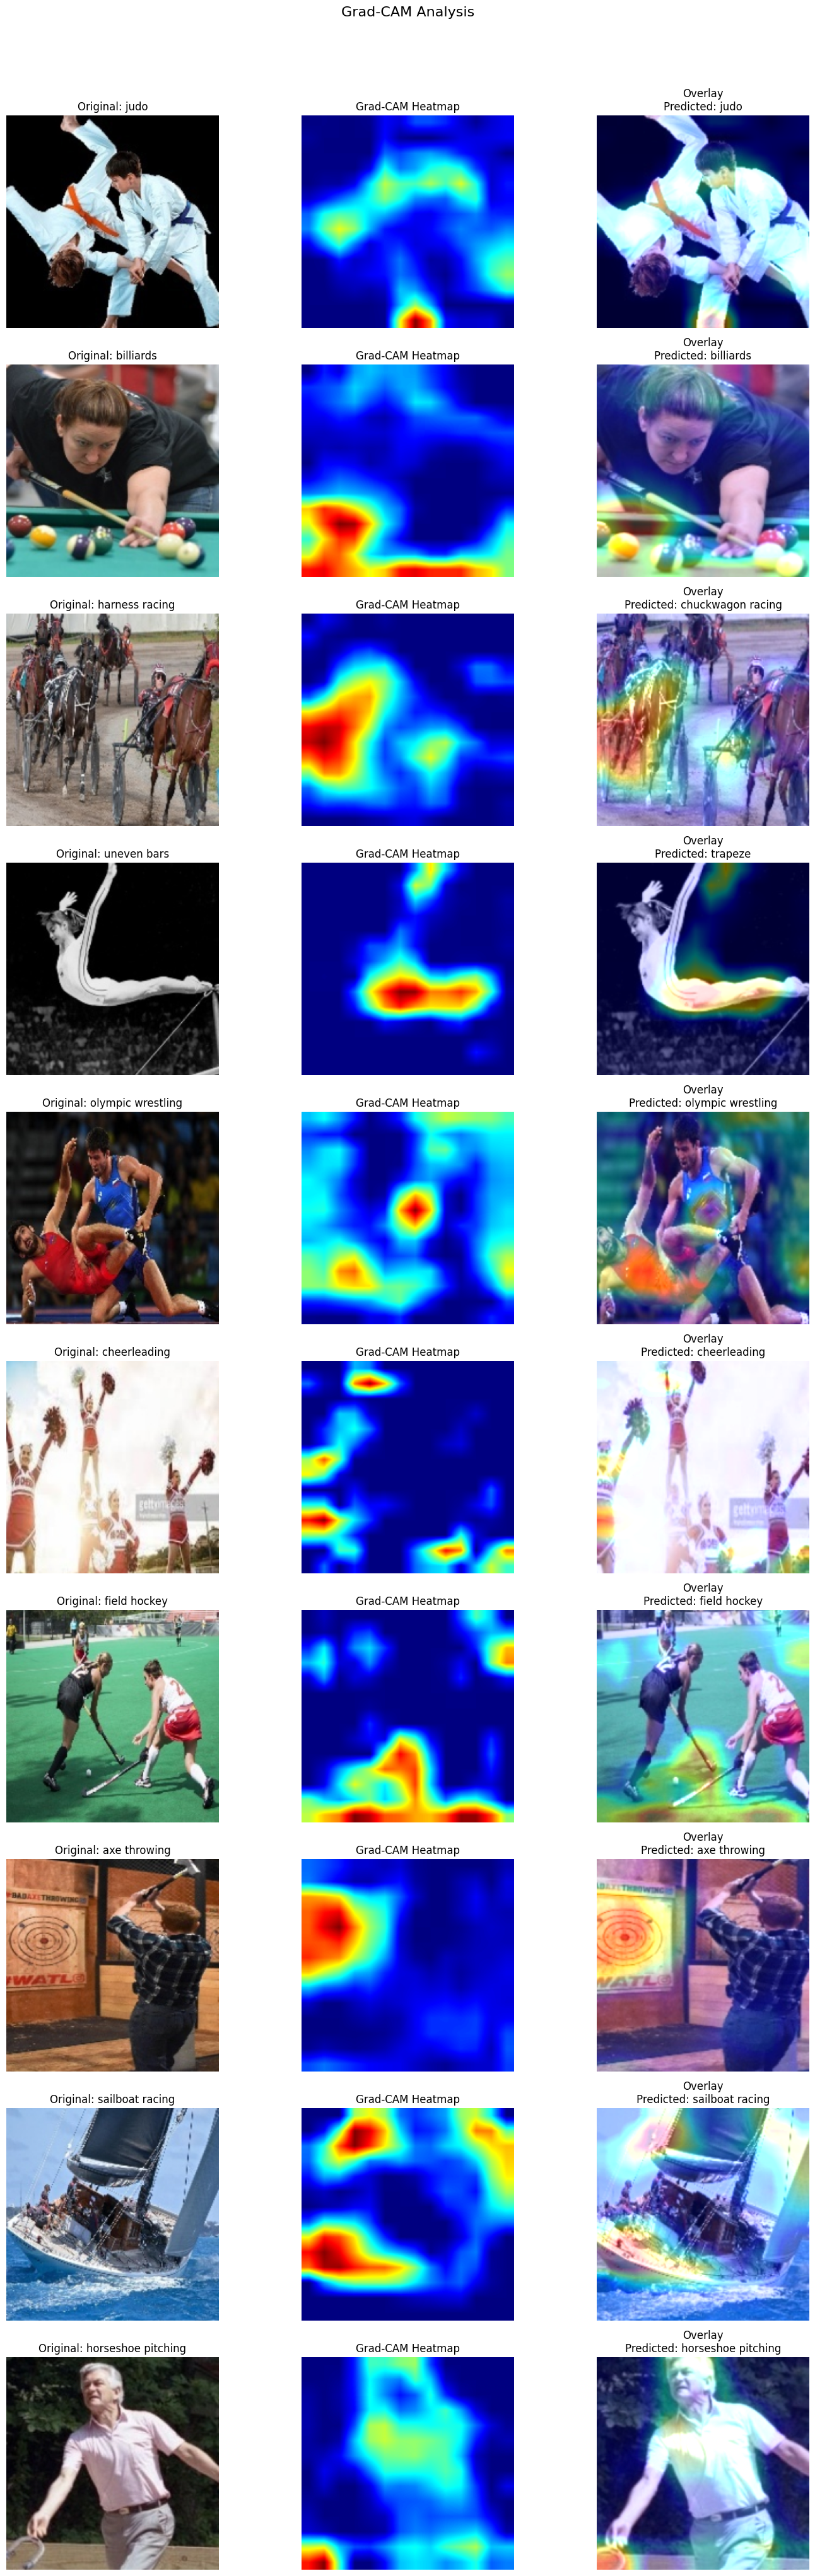

In [13]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to the target layer
        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        # Set model to evaluation mode
        self.model.eval()

        # Forward pass to get outputs
        outputs, _ = self.model(x)

        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()

        # Create a one-hot vector for the target class
        one_hot = torch.zeros_like(outputs)
        one_hot[0][class_idx] = 1

        # Backward pass to compute gradients
        self.model.zero_grad()
        outputs.backward(gradient=one_hot, retain_graph=True)

        # Get the feature maps and gradients
        feature_maps = self.feature_maps.squeeze(0)
        gradients = self.gradients.squeeze(0)

        # Calculate weights (alpha_k) by global average pooling the gradients
        weights = torch.mean(gradients, dim=[1, 2])

        # Create the heatmap (L_Grad-CAM)
        heatmap = torch.zeros(feature_maps.shape[1:], device=x.device)
        for i, w in enumerate(weights):
            heatmap += w * feature_maps[i]

        # Apply ReLU
        heatmap = torch.relu(heatmap)

        # Normalize the heatmap
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy()

def show_cam_on_image(img_tensor, heatmap):
    # Convert tensor image to numpy array for OpenCV
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    img  = np.uint8(255 * img)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # --- NEW: invert the heatmap so high activations become low gray values ---
    heatmap = 1.0 - heatmap
    heatmap = np.clip(heatmap, 0, 1)

    # Convert to 0–255 & apply colormap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img, heatmap
# --- Execution ---
print("\n--- Running Grad-CAM on 10 random validation images ---")

# Instantiate Grad-CAM
# The target layer is the last convolutional layer before the classifier
grad_cam = GradCAM(model, model.conv1x1)

# Get 10 random images from the validation set
val_dataset_untransformed = datasets.ImageFolder(valid_dir, transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
]))

random_indices = random.sample(range(len(val_dataset_untransformed)), 10)

fig, axes = plt.subplots(10, 3, figsize=(15, 40))
fig.suptitle("Grad-CAM Analysis", fontsize=16, y=1.02)

for i, idx in enumerate(random_indices):
    original_pil_img, label_idx = val_dataset_untransformed[idx]

    # Preprocess the image for the model
    input_tensor = data_transforms['valid'](original_pil_img).unsqueeze(0).to(device)

    # Generate the heatmap
    heatmap = grad_cam(input_tensor)

    # Get the predicted class
    output, _ = model(input_tensor)
    pred_idx = output.argmax().item()

    # Visualize
    superimposed_img, heatmap_img = show_cam_on_image(input_tensor.squeeze(0), heatmap)

    # Original Image
    axes[i, 0].imshow(original_pil_img)
    axes[i, 0].set_title(f"Original: {class_names[label_idx]}")
    axes[i, 0].axis('off')

    # Heatmap
    axes[i, 1].imshow(heatmap_img)
    axes[i, 1].set_title("Grad-CAM Heatmap")
    axes[i, 1].axis('off')

    # Superimposed Image
    axes[i, 2].imshow(superimposed_img)
    axes[i, 2].set_title(f"Overlay\nPredicted: {class_names[pred_idx]}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()